In [1]:
import osmnx as ox
import networkx as nx
import pickle
import math
import geopandas as gpd
import pandas as pd


In [2]:
class DirectionInstruction:
    def __init__(self, text):
        self.text=text
        self.data={}
    def extend(self,label='null', value='null'):
        self.data[label] = value

In [3]:

class RouteDescription:
    def __init__(self, destination):
        #self.origin = origin
        self.destination = destination
        self.steps = []

    def addStep(self, directionInstruction):
        self.steps.append(directionInstruction)

In [4]:
graphMiddle = "Van Lennepbuurt, Amsterdam, North Holland, Netherlands"
place_name = "Albert Heijn, 186, Amstelveenseweg, Schinkelbuurt, Amsterdam, North Holland, Netherlands, 1075XR, Netherlands"

In [5]:
#traffic_signals = ox.geometries.geometries_from_address(place_name, tags = {"highway":"traffic_signals"} )

In [6]:
#crossings=ox.geometries.geometries_from_address(place_name, tags = {"crossing":"marked"} )

In [7]:
#roundabouts=ox.geometries.geometries_from_address(place_name, tags = {"junction":"roundabout"} )

In [8]:
#highways = ox.geometries.geometries_from_address(place_name,dist=650, tags = {"highway":["motorway","trunk", "primary", "secondary","tertiary","unclassified", "residential","road"]} )

In [9]:
#graph = ox.graph_from_address(place_name, network_type='drive',simplify = True)
#ox.distance.nearest_nodes(graph, 8.435432953597548, 47.39719131318801)
#ox.plot.plot_graph_routes(graph,["N", "N2814628451"] )

In [10]:
#CHANGE BACK TO MIDDLE
ox.settings.all_oneway = False
ox.settings.useful_tags_node = ["ref", "highway", "traffic_signals"] # Default is ["ref", "highway"]
ox.settings.useful_tags_way = ["bridge", "tunnel", "oneway", "lanes", "ref", "name", "highway", "maxspeed", "service","junction", "turn","destination", "destination:ref"] # Default is ["bridge", "tunnel", "oneway", "lanes", "ref", "name", "highway", "service", "access", "area", "landuse", "width", "est_width", "junction"]
custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential|road"]'
G = ox.graph.graph_from_address(graphMiddle,dist=8000, network_type='drive',simplify=True, custom_filter=custom_filter)

In [11]:
def linestring_to_points(feature,line):
    return {feature:line.coords}

In [12]:
def calculate_direction(line):
    A=line[0]
    B=line[1]
    begin=math.atan2( B[1] - A[1], B[0] - A[0] ) * ( 180 / math.pi )

    C=line[-2]
    D=line[-1]
    end=math.atan2( D[1] - C[1], D[0] - C[0] ) * ( 180 / math.pi )

    return {'begin':begin, 'end':end}

In [13]:
def stringify(string):
    if isinstance(string, list):
        return ' '.join(map(str, string))
    return string

In [14]:
# create nodes, edges GeoDataFrames and fill in all edge geometry attributes
# then re-create a MultiDiGraph from those GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G, fill_edge_geometry=True)
#extract the points from the LineStrings, the apply function doesn't require a dict as they remain indexed in the output DataFrame.
edges['points'] = edges.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
# calculate the direction of the way at the beginning and ending (to decide ways connected but in opposite directions)
edges['directions'] = edges.apply(lambda x: calculate_direction(x['points']), axis=1)
# reanme name attribute (it is already used by the edge u, v, r struct)
edges['streetName'] = edges.apply(lambda x: stringify(x['name']), axis=1)
edges.rename(columns={'name':'Name'})
edges['U'] = edges.apply(lambda x: x.name[0], axis=1)
edges['V'] = edges.apply(lambda x: x.name[1], axis=1)
edges['REF'] = edges.apply(lambda x: stringify(x['ref']),axis=1)
G2 = ox.utils_graph.graph_from_gdfs(nodes, edges, graph_attrs=G.graph)
for u, v, data in G2.edges(keys=False, data=True):
    assert 'geometry' in data

#remove the attribute containing Linestring.
att_list = ['geometry']
for n1, n2, d in G2.edges(data=True):
    for att in att_list:
        d.pop(att, None)

In [15]:
#simple_G=ox.simplification.simplify_graph(G2)

In [16]:
#projected=ox.project_graph(simple_G, to_crs='EPSG:3035')
projected=ox.project_graph(G2, to_crs='EPSG:3035')
#have to work on tolerance pl:(https://nominatim.openstreetmap.org/ui/details.html?osmtype=W&osmid=89524318)
G_with_intersection = ox.simplification.consolidate_intersections(projected, tolerance=5, rebuild_graph=True, dead_ends=True, reconnect_edges=True)

In [17]:
#print(ox.projection.is_projected('EPSG:3035'))
#ox.plot_graph_folium(simple_G, node_color='g',figsize=(30,30))
#ox.plot_graph(G_with_intersection, node_color='g',figsize=(50,50))
#ox.plot_graph_folium(G2,popup_attribute="osmid")

In [18]:
#nodes, edges = ox.graph_to_gdfs(G_with_intersection)

In [19]:
#nx.get_edge_attributes(G_with_intersection,name='osmid')

In [20]:
class Point:
    def __init__(self, x,y):
        self.x=x
        self.y=y

In [21]:
def is_right(a, b, c):
    return (b.x - a.x)*(c.y - a.y) > (b.y - a.y)*(c.x - a.x)
    #Cross Product
    #Where a = line point 1; b = line point 2; c = point to check against.
    #If the formula is equal to 0, the points are colinear.
    #If the line is horizontal, then this returns true if the point is above the line.

In [22]:
a = Point(47.4488,19.0714)
b = Point(47.4523,19.0714)
cl = Point(47.4557,19.0654)
cr = Point(47.4565,19.0761)
is_right(a,b,cr)

True

In [23]:
def list_duplicates(l):
    seen = set(l)
    return list(seen)

In [24]:
def get_closest_node(given, target, G):
    distance=9999
    for i, node in G[0].iterrows:

        #print(edge[3]["name"])
        if node.name == given:
            #print(edge)
            for edge2 in G_with_intersection.edges(data=True,keys=True):
                if edge2[3]["name"] == target:
                    if edge2[0] == edge[1] or edge2[1] == edge[0]:
                        original_id = G_with_intersection.nodes[edge[1]]["osmid_original"]
                        if type(original_id) is int:
                            nodes.append(original_id)
                        else:
                            nodes=original_id.strip('][').split(', ')

In [25]:
def find_street_end(street):
    beginWays=[]
    endWays=[]
    for way in street:
        numInWay = 0
        numOutWay = 0
        for otherway in street:
            if otherway.U != way.V or otherway.V != way.U:
                if way.U == otherway.V:
                    numInWay+=1
                if way.V == otherway.U:
                    numOutWay+=1
        # numInWay != 0 will find all possible sections (could be usinted somehow))
        if numInWay == 0 :
            beginWays.append(way)
        if numOutWay == 0 :
            endWays.append(way)

    return {"beginWays":beginWays,"endWays":endWays}

In [26]:
def recursive_find_section(street,r, direction="beginWays"):
    possibilites=[]
    for way in street:
            if (direction=="beginWays" and way.U == r[-1].V and way.V != r[-1].U) \
                    or (direction=="endWays" and way.V == r[-1].U and way.U != r[-1].V):
                possibilites.append(way)

    if possibilites:
        closest=possibilites[0]
        for candidate in possibilites:
            if abs(candidate.directions["begin"]-r[-1].directions['end']) < abs(closest.directions["begin"]-r[-1].directions['end']):
                closest=candidate
        if (pd.DataFrame.from_records(r)['U']==closest.U).any():
            return r
        else:
            r.append(closest)
            return recursive_find_section(street,r, direction)
    return r

In [27]:
def find_street_section(street,street_ends, direction):
    streetSections=[]
    for beginWay in street_ends[direction]:
        route=recursive_find_section(street,[[beginWay]], direction)
        streetSections.append(pd.DataFrame.from_records(route))
    return streetSections

In [28]:
def sort_street(street):
    street_ends=find_street_end(street) # correct
    streetSectionsForward=find_street_section(street,street_ends,"beginWays")
    streetSectionsBackward=find_street_section(street,street_ends,"endWays")

    return {"forward":streetSectionsForward,"backward":streetSectionsBackward}

In [29]:
def organise_edge_of_street(street,graph):
    edges=[]
    #nodes,EDGES=ox.graph_to_gdfs(graph)
    #for edge in graph.edges(data=True,keys=True):
    for index, edge in graph[1].iterrows():
        #Check if a given key already exists in a dictionary
        if isinstance(edge.streetName, str):
            if street in edge.streetName:
                edges.append(edge)
        if isinstance(edge.streetName, list):
            for name in edge.streetName:
                if street in name:
                    edges.append(edge)
        if isinstance(edge.ref, str):
            if  street in edge.ref:
                edges.append(edge)
        if isinstance(edge.ref, list):
            for name in edge.ref:
                if street in name:
                    edges.append(edge)
    return sort_street(edges)

In [30]:
#for n, nbrsdict in G.adjacency():
#    for nbr, keydict in nbrsdict.items():
#       print(nbr, keydict)

In [31]:
graph_G = ox.graph_to_gdfs(G2)
#street = organise_edge_of_street("Amstelveenseweg",graph_G)

In [32]:
def get_junction_from_distance(node,way,distance):
    #assumes direction is calculated
    beginNode=None
    currentDistance=0
    nextDistancesByIndex=[0]
    for i, begin in way.iterrows():
        if beginNode:
            nextDistancesByIndex.append(currentDistance)
            currentDistance+=begin.length
        if begin.U==node:
            beginNode=i
            currentDistance=begin.length

    closestIndex=0
    for index,dst in enumerate(nextDistancesByIndex):
        if abs(dst-distance) < abs(nextDistancesByIndex[closestIndex]-distance):
            closestIndex=index
    return way.iloc[beginNode+closestIndex].U

In [33]:
#print(get_junction_from_distance(46307138,street['forward'][1], 300))

In [34]:
def get_junction_from_ordinal(node,way,ordinal):
    #assumes direction is calculated
    if ordinal == -1:
        return way.iloc[-1].U
    for i, begin in way.iterrows():
        if begin.U==node:
            return way.iloc[ordinal+i].U

In [35]:
#print(get_junction_from_ordinal(46307138,street['forward'][1], 6))

In [344]:
def get_nodes_of_way(ways, g, direction = "forward",):
    if direction == 'backward':
        ways=ways.iloc[::-1]
    nodes=[ways.iloc[0].U]
    for way in ways.itertuples():
        nodes.append(way.V)
    route=[nodes[0]]
    for n in nodes:
        last =route[-1]
        r = nx.shortest_path(g, last , n)
        if len(r) > 1:
            route+=r[1:]
    return route

In [337]:
#p=get_nodes_of_way(street['backward'][0],'backward')
#print(p)
#ox.plot_graph_route(G2, p)

In [273]:
def get_intersections_of_streets(first, second, destination, graph, strict=False):
    edges = pd.DataFrame()
    edgesFirst = graph[1][(graph[1].REF.str.contains(first, na=False))|(graph[1].streetName.str.contains(first, na=False))]
    edgesSecond =graph[1][(graph[1].REF.str.contains(second, na=False))|(graph[1].streetName.str.contains(second, na=False))|(graph[1].destination.str.contains(second, na=False))|(graph[1]['destination:ref'].str.contains(second, na=False))]
    destinationEdges = graph[1][((graph[1].REF.str.contains(second, na=False))|(graph[1].streetName.str.contains(second, na=False))|(graph[1].destination.str.contains(second, na=False))|(graph[1]['destination:ref'].str.contains(second, na=False)))&((graph[1].destination.str.contains(destination, na=False))|(graph[1]['destination:ref'].str.contains(destination, na=False)))]
    if not destinationEdges.empty:
        edgesSecond=destinationEdges
    if strict:
        edgesSecond =graph[1][(graph[1].REF.str.contains(second, na=False))|(graph[1].streetName.str.contains(second, na=False))]
    for i, edge in edgesFirst.iterrows():
        matchingEdges= edgesSecond[edgesSecond.U==edge.V]
        edges=pd.concat([edges, matchingEdges], ignore_index = True, axis = 0)
    return edges

In [274]:
def check_name(street, edge):
    return is_in_ref(street, edge.streetName) or is_in_ref(street,edge.REF)

In [275]:
def is_in_ref(street, ref):
    if isinstance(ref, str):
        if  street.lower() in ref.lower():
            return True
    return False

In [276]:
def is_in_Name(street, streetName):
    if isinstance(streetName, str):
        if street.lower() in streetName.lower():
            return True
    return False

In [277]:
#dest = get_intersections_of_streets('Kolkweg','A10', 'west', graph_G)

In [278]:
def find_shortest_path(g,origin="Albert Heijn Distributiecentrum, 1, Hoofdtocht, Westerspoor, Zaandam, Zaanstad, North Holland, Netherlands, 1507CH, Netherlands",destination="Kolkweg, Oostzaan, North Holland, Netherlands, 1511 HZ, Netherlands"):
    orig_node   = get_node_from_address(origin,g)
    target_node = get_node_from_address(destination,g)
    return nx.shortest_path(g, orig_node, target_node)

In [279]:
def get_node_from_address(address,g):
    y, x = ox.geocoder.geocode(address)
    return ox.distance.nearest_nodes(g, x, y )

In [280]:
def find_way_from_ends(u,v,g):
    return pd.DataFrame(g[1][(g[1].U==u)&(g[1].V==v)])

In [281]:
def get_roundabaouts(edges):
    roundabaoutsEdges=[]
    for index, edge in edges.iterrows():
        if edge.junction == 'roundabout':
            roundabaoutsEdges.append(edge)
    roundabaouts=[]
    already_in=[]
    for index, e in enumerate(roundabaoutsEdges):
        if e.U not in already_in:
            route = recursive_find_section(roundabaoutsEdges,[e])
            roundabaout=pd.DataFrame.from_records(route)
            roundabaouts.append(roundabaout)
            for i,r  in roundabaout.iterrows():
                already_in.append(r.U)
    return roundabaouts

In [282]:
ROUNDABAOUTS = get_roundabaouts(graph_G[1])

In [283]:
#coord = ox.geocoder.geocode(place_name)
#area = ox.geocode_to_gdf(["N2814628451"], by_osmid=True)

In [284]:
'''
files = ['/Users/balazs/Desktop/Thesis/Data/AH/Amstelveenseweg\ 186.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/August\ Allebeplein\ 12.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Bilderdijkstraat\ 37.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Bourgondischelaan\ 14-28.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Brink\ 20.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Eef\ Kamerbeekstraat\ 168.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Groenhof\ 144.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Haarlemmerdijk\ 1.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Karspeldreef\ 1389.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Maalderij\ 31.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Rembrandthof\ 49.txt',
'/Users/balazs/Desktop/Thesis/Data/AH/Westelijke\ Halfrond\ 70.txt']

for f in files:
    %run NLP.py {f}
'''

"\nfiles = ['/Users/balazs/Desktop/Thesis/Data/AH/Amstelveenseweg\\ 186.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/August\\ Allebeplein\\ 12.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Bilderdijkstraat\\ 37.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Bourgondischelaan\\ 14-28.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Brink\\ 20.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Eef\\ Kamerbeekstraat\\ 168.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Groenhof\\ 144.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Haarlemmerdijk\\ 1.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Karspeldreef\\ 1389.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Maalderij\\ 31.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Rembrandthof\\ 49.txt',\n'/Users/balazs/Desktop/Thesis/Data/AH/Westelijke\\ Halfrond\\ 70.txt']\n\nfor f in files:\n    %run NLP.py {f}\n"

In [285]:
def readFile(address):
    with open(f'../../Data/Routes/{address}.pickle', 'rb') as file:
        return pickle.load(file)

In [286]:
def get_closest_way(begin_u,ways,g):
    shorest=9999
    way = None
    for i, w in ways.iterrows():
        try:
            path= nx.shortest_path_length(g, begin_u, w.U)
            if path < shorest:
                shorest=path
                way=w
        except nx.NetworkXNoPath:
            print('No path')
    return pd.DataFrame(way)

In [287]:
def find_intersection(way,street, destination, g , graph, strict=False ):
    nextWayPossible=pd.DataFrame()
    last = way.iloc[-1]
    if isinstance(last['name'], list):
        for s in last['name']:
            next = get_intersections_of_streets(s,street, destination, g,strict)
            if not next.empty:
                nextWayPossible=pd.concat([nextWayPossible,next], ignore_index = True, axis = 0)
    if isinstance(last['name'], str):
        next = get_intersections_of_streets( last['name'],street, destination, g,strict)
        if not next.empty:
            nextWayPossible=pd.concat([nextWayPossible,next], ignore_index = True, axis = 0)
    if isinstance(last['ref'], list):
        for s in last['ref']:
            next = get_intersections_of_streets(s,street, destination, g,strict)
            if not next.empty:
                nextWayPossible=pd.concat([nextWayPossible,next], ignore_index = True, axis = 0)
    if isinstance(last['ref'], str):
        next = get_intersections_of_streets( last['ref'],street, destination, g,strict)
        if not next.empty:
                nextWayPossible=pd.concat([nextWayPossible,next], ignore_index = True, axis = 0)
    return nextWayPossible

In [288]:
def process_Route(Route, graphXML, graph):
    destination=Route.destination
    lastWay=pd.DataFrame()
    lastWay=pd.concat([lastWay,find_way_from_ends(find_shortest_path(graph)[-2],find_shortest_path(graph)[-1],graphXML)],ignore_index = True, axis = 0)
    for step in Route.steps:
        data = step.data
        destination=  ''
        if 'neighbourhood'in data:
            destination=data['neighbourhood']
        if "city"in data:
            destination=data["city"]
        nextWayPossible=pd.DataFrame()
        if "street" in data:
             nextWayPossible= find_intersection(lastWay,data['street'], destination, graphXML , graph, False )
        #print(nextWayPossible)
        #return get_closest_way(way.iloc[-1].U,nextWayPossible,graph).T
        nextWay=get_closest_way(lastWay.iloc[-1].U,nextWayPossible,graph)
        #return nextWay.T
        lastWay=pd.concat([lastWay,nextWay.T],ignore_index=True, axis = 0)
        lastWay = iterate_until_named_road(lastWay,graphXML)
        if "street" in data:
            lastWay = find_street_from_between(data['street'], lastWay, graphXML, graph)
    return lastWay

In [289]:
def iterate_until_named_road(ways,g):
    nextWay=ways.iloc[-1]
    if nextWay.notnull().streetName or nextWay.notnull().ref:
        return ways
    else:
        nextWay=pd.DataFrame(iterate_until_named_road_recursive(nextWay,g)).T
        #print(nextWay)
        return pd.concat([ways,nextWay],ignore_index=True, axis = 0)

In [290]:
def iterate_until_named_road_recursive(way,g):
    if way.notnull().streetName or way.notnull().ref:
        return way
    if way.isnull().streetName or way.isnull().ref:
        possibles= pd.DataFrame(g[1][g[1].U==way.V])
        nextWay=possibles.iloc[0]
        return iterate_until_named_road_recursive(nextWay,g)

In [346]:
def find_street_from_between(street, ways, g, graph):
    last = ways.iloc[-1]
    if not check_name(street, last):
        possibles=find_intersection(ways,street, '', g , graph, True )
        next=get_closest_way(last.U,possibles,graph).T
        return pd.concat([ways,next],ignore_index = True, axis = 0)
    return ways

In [292]:
ROUTE=readFile('Amstelveenseweg 186')

In [318]:
final_route=process_Route(ROUTE, graph_G, G2)
#graph_G[1][graph_G[1].U==2972589242]

                                               osmid        highway oneway  \
0  [7377831, 7377192, 221380395, 75922269, 679563...  motorway_link   True   

  reversed    length          bridge  \
0    False  2712.015  [yes, viaduct]   

                                               name  \
0  [Ringweg-West, Ringweg-Noord, Eerste Coentunnel]   

                                              points  \
0  [(4.8732441, 52.4265386), (4.8733583, 52.42642...   

                                          directions  \
0  {'begin': -44.46832663173141, 'end': -142.0265...   

                                     streetName  ...   lanes        ref  \
0  Ringweg-West Ringweg-Noord Eerste Coentunnel  ...  [2, 3]  [A10, A8]   

      REF junction destination destination:ref tunnel turn service  \
0  A10 A8      NaN         NaN             NaN    yes  NaN     NaN   

                                            geometry  
0  LINESTRING (4.8732441 52.4265386, 4.8549523 52...  

[1 rows x 23 columns]


[46590567, 46596191, 6553626376, 46595474, 2972589242, 46523177, 2972598756, 2972598759, 4836569840, 896347488, 896347553, 46465704, 46440554, 46428820, 46402893, 896347542, 46338568, 46327606, 46325415, 46325417, 798748062, 1432668022, 440673001, 4519063338, 2020233480, 2090532549, 1468478488, 46325737, 1468487607, 1468487600]


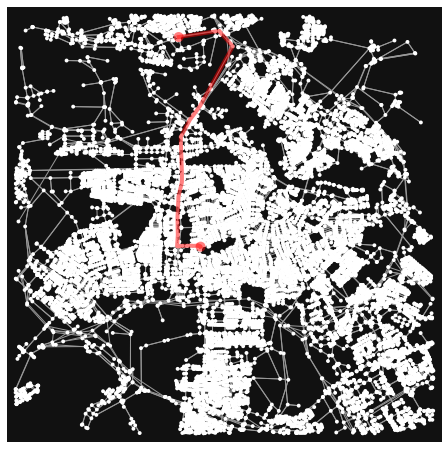

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [345]:
p=get_nodes_of_way(final_route,G2, 'forward')
print(p)
#ox.plot_graph_route(G2, p)

In [ ]:
address = 'Amstelveenseweg 186'
Route=readFile(address)
last_step = 'Coentunnelweg'
path = []#get_intersection_of_streets(last_step,last_step)
print(path, type(path))
for step in Route.steps:
    try:
        street = step.data['street']
        print(street)
        r = get_intersection_of_streets(last_step,street)
        print(r)
        last_step = street
        path.extend(r)
        #assert x
    except KeyError as AssertionError:
        pass
end = find_shortest_path(last_step,Route.destination)
path.extend(end)
print(path)
#path = sum(path, [])
#path = list(dict.fromkeys(path))

In [347]:
!jupyter nbconvert --to script *.ipynb

[NbConvertApp] Converting notebook NLP.ipynb to script
[NbConvertApp] Writing 9296 bytes to NLP.py
[NbConvertApp] Converting notebook map.ipynb to script
[NbConvertApp] Writing 20020 bytes to map.py


In [296]:
#n1 = 46494259
#n2 = 3657588020
#r=  nx.shortest_path(G, n1, n2)
#ox.plot_graph_route(G, r)
#ox.save_graph_shapefile(G, filename=os.path.join('~/test_graph'))